# (10) Gaus—Fit—1

**Motivation**: Gaussian fit with no nonlinearity (i.e., probabilistic PCA). Using ```exact``` training method. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 1
device = f'cuda:{device_idx}'

model_type = 'gaussian'

## Build model + trainer

In [3]:
kws_vae = dict(latent_act=None)
kws_tr = dict(method='exact', temp_anneal_portion=0.0, temp_stop=1.0)

vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**kws_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**kws_tr), device=device)

In [4]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
| GaussianVAE |  393.2 K   |
|     ---     |    ---     |
|    fc_enc   |  262.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

gaussian_None_DOVES_z-512_<lin|lin>
exact_ep3600-b1000-lr(0.005)_beta(1:0x0.5)_gr(500)

In [5]:
vae.fc_dec.bias, vae.fc_enc.bias #.shape

(None, None)

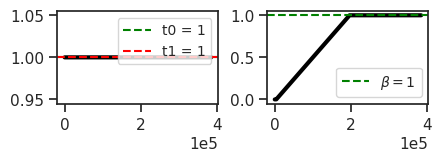

In [6]:
tr.show_schedules()

## Train

In [7]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3600, avg loss: 161.661954: 100%|███████████████████████| 3600/3600 [35:46<00:00,  1.68it/s]


## Eval

### Loss vld (freeze)

In [8]:
data, loss, rates = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 122.362015, 'kl': 37.97376, 'kl_diag': 0.073780365, 'tot': 160.33577}

### Identify dead neurons

In [9]:
dead_thres = 0.0
dead = loss['kl_diag'] < dead_thres
dead.sum()

0

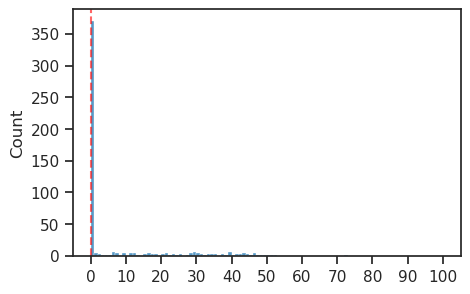

In [10]:
ax = sns.histplot(loss['kl_diag'] * 100, bins=np.linspace(0, 100, 101))
ax.locator_params(axis='x', nbins=15)
ax.axvline(dead_thres * 100, color='r', ls='--', alpha=0.6)
plt.show()

### Cosine sim enc/dec

In [17]:
with torch.inference_mode():
    w_dec = tr.model.fc_dec.weight.detach().data
    w_enc = tr.model.fc_enc.weight.detach().data[:512]

    w_dec = w_dec[:, ~dead]
    w_enc = w_enc[~dead]

    cos_sim = F.cosine_similarity(w_dec.T, w_enc)
    slope = torch.einsum('ic, ci -> c', w_dec, w_enc)
    slope /= torch.norm(w_enc, dim=1).pow(2)

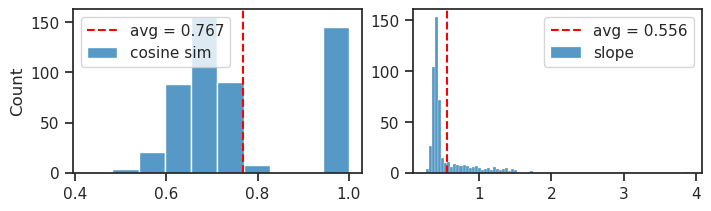

In [18]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(to_np(cos_sim), label='cosine sim', ax=axes[0])
sns.histplot(to_np(slope), label='slope', ax=axes[1])

_avg = cos_sim.mean().item()
axes[0].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')
_avg = slope.mean().item()
axes[1].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')

for ax in axes.flat:
    ax.legend()
axes[1].set_ylabel('')
plt.show()

### Plot enc/dec weights

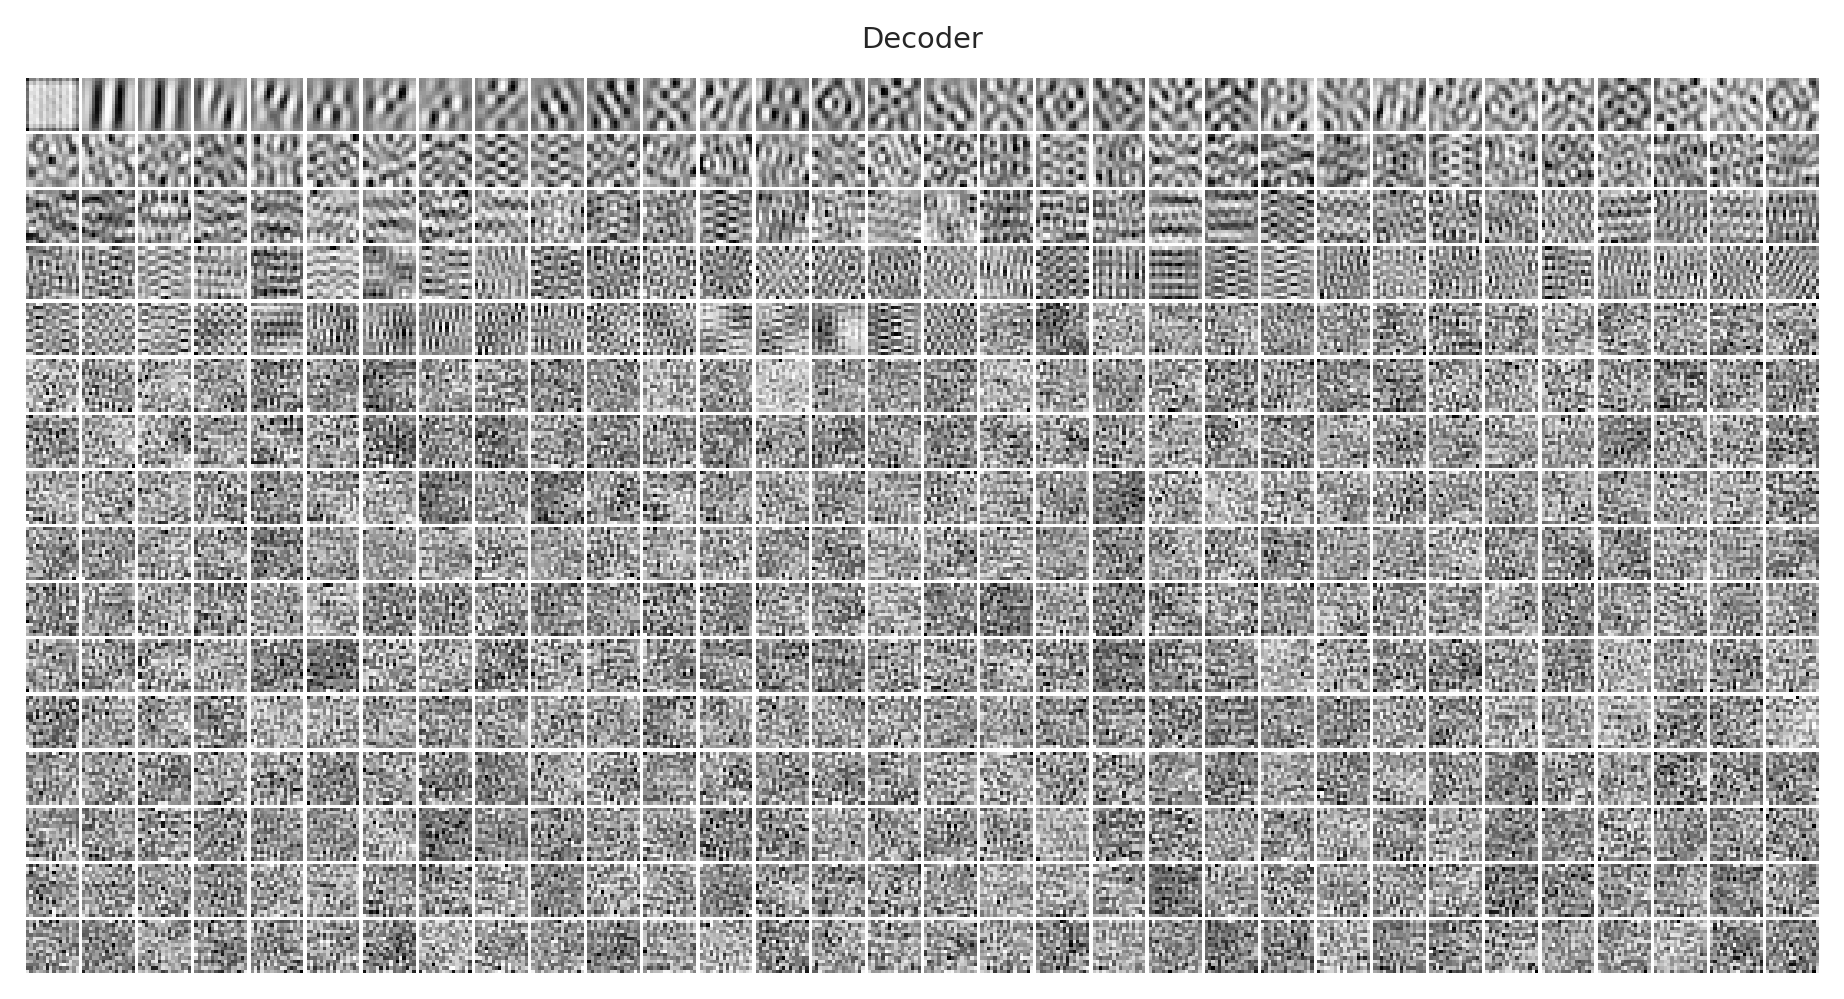

In [19]:
order = np.argsort(rates['sigma'].mean(0))
tr.model.show('dec', order=order, dpi=260);

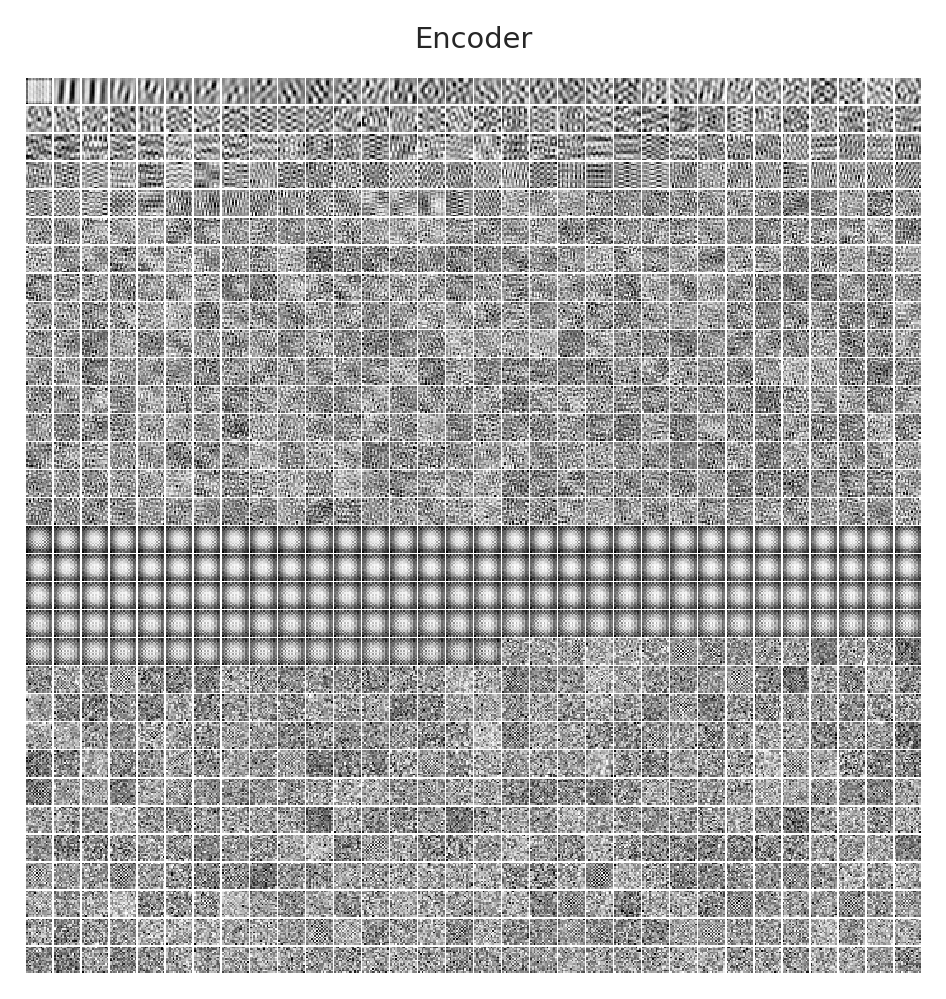

In [20]:
order = np.argsort(rates['sigma'].mean(0))
order = np.concatenate([order, order + len(order)])

tr.model.show('enc', order=order, nrows=32, dpi=260);